In [6]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')
import seaborn
import os
import tempfile
import time
from collections import namedtuple

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex = True)

from functions import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Non interacting

## Time Series

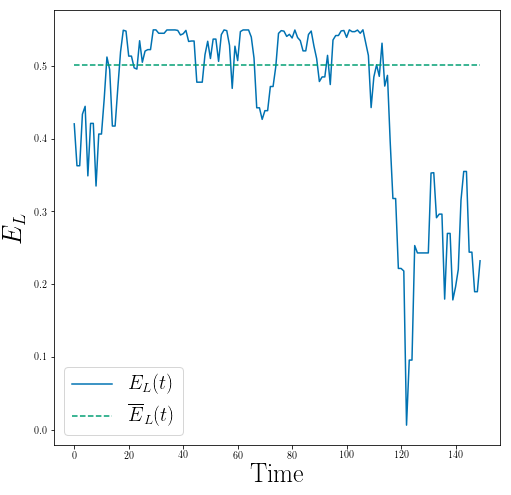

{'variance': 0.004588707836379035, 'time': 0.062505, 'acceptance-rate': 0.8535118103, 'energy-mean': 0.5021693646491423}


In [22]:
E, _, meta = run_MC(n=1, dims=1, n_mc=2**18, alpha=0.55, importance=False, step=1)
time_series_plot(E, saveas='../results/time-series-example.png')
print(meta)

## Configuration Comparison

In [11]:
make_configuration_table('../results/vmc_configurations.csv', n_mc=1000, importance=False, steps=(1, 0.1))
make_configuration_table('../results/vmc_imp_configurations.csv', n_mc=1000, importance=True, steps=(0.1, 0.01, 0.001))

Dims, Nparticles, Analytic, step, Energy, Variance, Acceptance, Time
1,   1, OFF , 1.000, 0.500000, 0.000000, 0.866, 5.960e-04
1,   1, OFF , 0.100, 0.500000, 0.000000, 0.995, 5.400e-04
1,   1, ON  , 1.000, 0.500000, 0.000000, 0.866, 3.890e-04
1,   1, ON  , 0.100, 0.500000, 0.000000, 0.995, 2.920e-04
1,  10, OFF , 1.000, 5.000000, 0.000000, 0.876, 9.675e-03
1,  10, OFF , 0.100, 4.999999, 0.000000, 0.997, 9.434e-03
1,  10, ON  , 1.000, 5.000000, 0.000000, 0.876, 1.353e-03
1,  10, ON  , 0.100, 5.000000, 0.000000, 0.997, 1.352e-03
1, 100, OFF , 1.000, 49.999990, 0.000000, 0.000, 5.754e-01
1, 100, OFF , 0.100, 49.999988, 0.000000, 0.999, 5.495e-01
1, 100, ON  , 1.000, 50.000000, 0.000000, 0.000, 9.845e-03
1, 100, ON  , 0.100, 50.000000, 0.000000, 0.999, 9.606e-03
1, 500, OFF , 1.000, 249.999947, 0.000000, 0.000, 1.350e+01
1, 500, OFF , 0.100, 249.999938, 0.000000, 0.999, 1.336e+01
1, 500, ON  , 1.000, 250.000000, 0.000000, 0.000, 4.214e-02
1, 500, ON  , 0.100, 250.000000, 0.000000, 0.999, 4

## Variation Plots

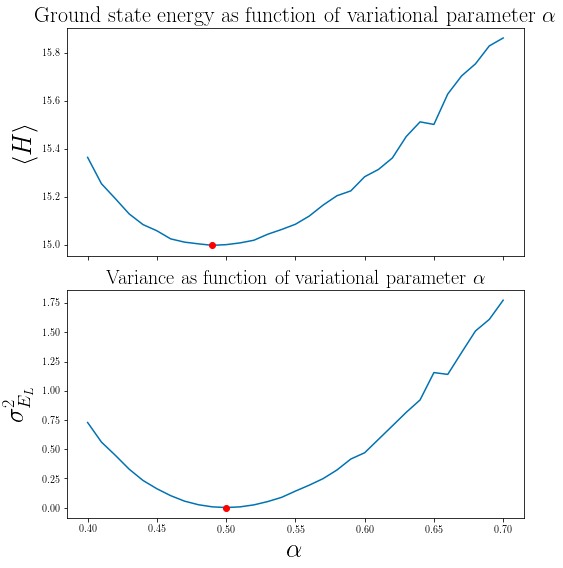

In [32]:
out = E_and_var_plot_for_alphas(np.linspace(0.4, 0.7, 31), 
                                n_mc=50000, importance=False, steps=[1],
                                dims=3, n=10, verbose=False,
                                saveas='../results/var-alpha-plot-noimp-50000.png')

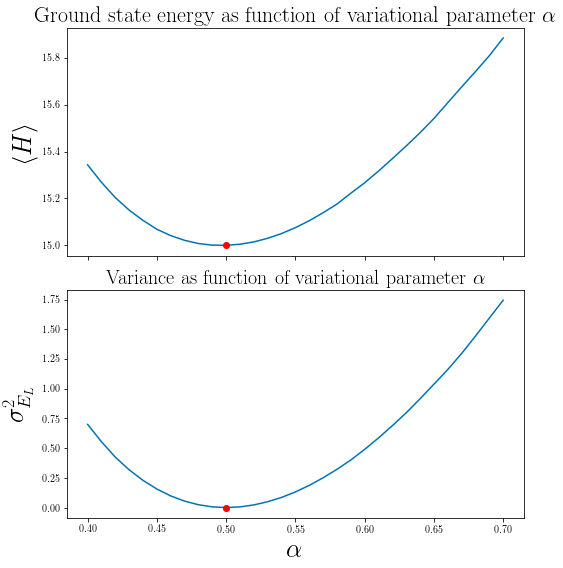

In [33]:
out = E_and_var_plot_for_alphas(np.linspace(0.4, 0.7, 31), 
                                n_mc=50000, importance=True, steps=[0.1],
                                dims=3, n=10, verbose=False,
                                saveas='../results/var-alpha-plot-imp-50000.png')

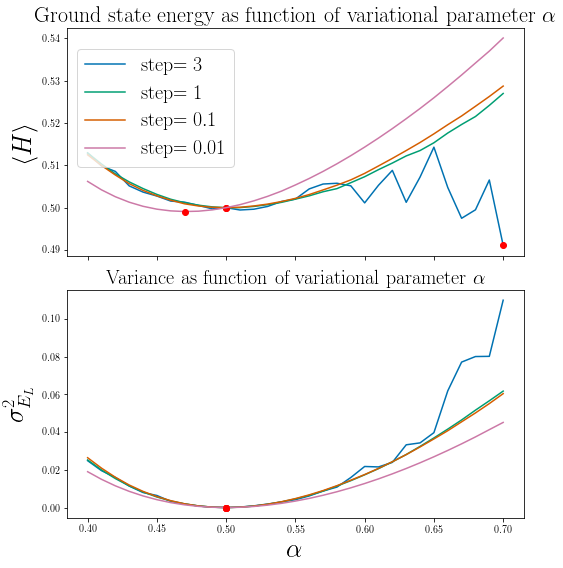

In [41]:
out = E_and_var_plot_for_alphas(np.linspace(0.4, 0.7, 31), 
                                n_mc=50000, importance=True, steps=[3, 1, 0.1, 0.01],
                                dims=1, n=1, verbose=False, saveas='../results/var-alpha-plot-imp-dts-50000.png')

Blocking warning: Blocked until stopped. Use more data if var != 0.


/home/bendik/drive/uio/10.semester/fys4411/project1/python/functions.py:222: RuntimeWarning: invalid value encountered in true_divide
  q = np.array([6.634897, 9.210340, 11.344867,


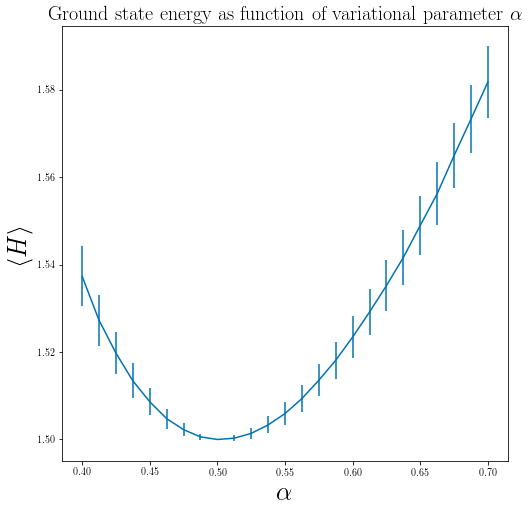

In [44]:
_ = proper_error_plot(np.linspace(0.4, 0.7, 25), importance=True, step=0.1, 
                      n_mc=2**14, dims=3, n=1, verbose=False,
                      saveas='../results/error-plot-3D-2-pow-14.png')

## Density plots

({'acceptance-rate': 0.86516818182,
  'energy-mean': 15.0,
  'time': 2.392172,
  'variance': 9.1945209491491892e-31},
 {'acceptance-rate': 0.83140545455,
  'energy-mean': 24.142150000000012,
  'time': 2.381979,
  'variance': 1.2863804582322685e-28})

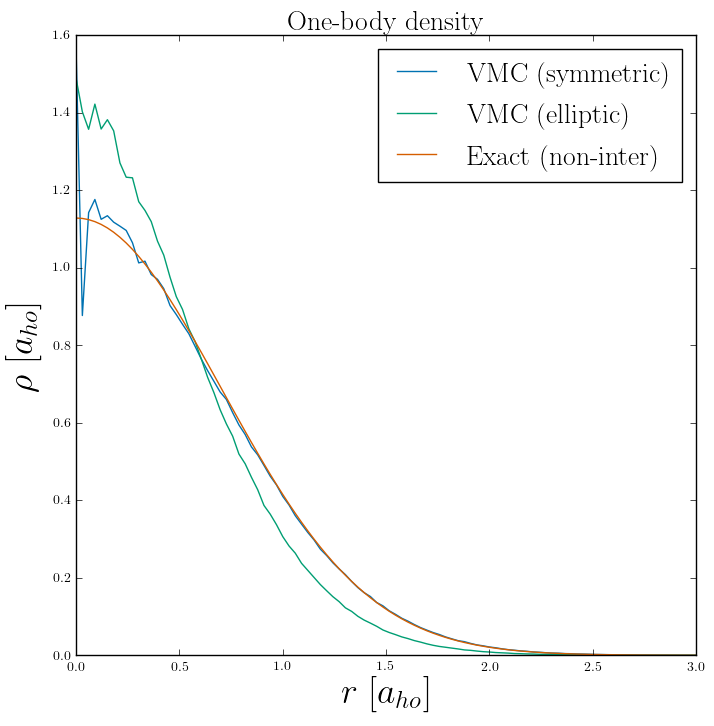

In [37]:
_, density_1, meta_1 = run_MC(n=10, dims=3, alpha=0.5, beta=1, omega_z=1, a=0.00, 
                              importance=False, n_mc=int(1e6), step=0.5, 
                              n_bins=100, max_radius=3)
_, density_2, meta_2 = run_MC(n=10, dims=3, alpha=0.5, beta=2.82843, omega_z=2.82843, a=0.00, 
                              importance=False, n_mc=int(1e6), step=0.5, 
                              n_bins=100, max_radius=3)
density_plot_multiple(np.array([density_1, density_2]), max_radius=3, alpha=0.5, draw_exact=True,
                      saveas='../results/one-body-3D-N10-noniter.png',
                      labels=['VMC (symmetric)', 'VMC (elliptic)'])
meta_1, meta_2

# Interacting System

In [133]:
interacting_result = dict()

In [134]:
ResultKey = namedtuple('ResultKey', 'N MC alpha')
ResultEntry = namedtuple('ResultEntry', 'energy density meta')
def run_inter(**kwargs):
    kwargs['dims'] = 3
    kwargs['beta'] = 2.82843
    kwargs['omega_z'] = 2.82843
    kwargs['a'] = 0.0043
    kwargs['importance'] = False
    kwargs['n_bins'] = 100
    kwargs['max_radius'] = 4
    kwargs['filename'] = '../data/interacting-run'
    return run_MC(**kwargs)

def run_and_store(**kwargs):
    result = run_inter(**kwargs)
    print(kwargs, result)
    interacting_result[ResultKey(kwargs['n'], kwargs['n_mc'], kwargs['alpha'])] = ResultEntry(*result)

In [136]:
for alpha in [0.4, 0.45, 0.5, 0.55, 0.6]:
    run_and_store(n=10, n_mc=2**17, alpha=alpha, step=0.5)

{'n': 10, 'n_mc': 131072, 'alpha': 0.4, 'step': 0.5} (array([24.63310106, 24.63310106, 24.62356281, ..., 24.66076011,
       24.66699863, 24.68476242]), array([1.42295608e-01, 1.87017084e-01, 2.24677275e-01, 2.07674671e-01,
       2.06211995e-01, 2.00777539e-01, 1.93611662e-01, 1.93825141e-01,
       1.82295755e-01, 1.75900474e-01, 1.69894937e-01, 1.61148880e-01,
       1.53260561e-01, 1.43076022e-01, 1.38507072e-01, 1.32589508e-01,
       1.17553240e-01, 1.13288362e-01, 1.06271403e-01, 1.01090990e-01,
       9.29581885e-02, 8.76836409e-02, 8.21173994e-02, 7.54295534e-02,
       6.88644374e-02, 6.27967802e-02, 5.83121592e-02, 5.15424919e-02,
       4.70328732e-02, 4.18221560e-02, 4.01547906e-02, 3.44558992e-02,
       3.06862790e-02, 2.79773366e-02, 2.47373602e-02, 2.17060076e-02,
       1.97298538e-02, 1.68097016e-02, 1.52822987e-02, 1.41718035e-02,
       1.20868856e-02, 1.13682266e-02, 9.86799952e-03, 8.21639954e-03,
       6.89322941e-03, 6.39654382e-03, 5.42684343e-03, 4.91906813e

In [ ]:
for alpha in [0.4, 0.45, 0.5, 0.55, 0.6]:
    run_and_store(n=50, n_mc=2**17, alpha=alpha, step=0.5)

{'n': 50, 'n_mc': 131072, 'alpha': 0.4, 'step': 0.5} (array([125.62616109, 125.59064306, 125.61466343, ..., 131.45787774,
       131.29263755, 131.29263755]), array([1.13836486e-01, 1.82951496e-01, 1.78243972e-01, 1.84599707e-01,
       1.87550276e-01, 1.72005680e-01, 1.63359839e-01, 1.71310440e-01,
       1.48459565e-01, 1.59459293e-01, 1.55443550e-01, 1.46373076e-01,
       1.39973974e-01, 1.35102266e-01, 1.29208922e-01, 1.21020342e-01,
       1.15879830e-01, 1.06775899e-01, 1.05459473e-01, 9.60746022e-02,
       8.92036608e-02, 8.29266383e-02, 7.52295051e-02, 7.33664818e-02,
       6.68939474e-02, 5.95164690e-02, 5.68663764e-02, 5.18537988e-02,
       4.69340779e-02, 4.40319616e-02, 3.97401909e-02, 3.57869869e-02,
       3.20647818e-02, 2.92541512e-02, 2.56403057e-02, 2.33316625e-02,
       2.03025963e-02, 1.82072272e-02, 1.54814549e-02, 1.38191804e-02,
       1.27519535e-02, 1.11197119e-02, 9.69794852e-03, 9.36940253e-03,
       7.99700836e-03, 6.88682333e-03, 6.14685438e-03, 5.167

In [ ]:
for alpha in [0.4, 0.45, 0.5, 0.55, 0.6]:
    run_and_store(n=100, n_mc=2**15, alpha=alpha, step=0.5)

{'n': 100, 'n_mc': 32768, 'alpha': 0.4, 'step': 0.5} (array([262.10203005, 261.99145161, 261.96255065, ..., 273.03467862,
       273.29750193, 273.29750193]), array([1.13836486e-01, 1.95148262e-01, 1.67759032e-01, 1.85307340e-01,
       1.66089299e-01, 1.69253589e-01, 1.51411490e-01, 1.57222333e-01,
       1.68289146e-01, 1.69502948e-01, 1.61902309e-01, 1.35577248e-01,
       1.40035869e-01, 1.41654627e-01, 1.30964277e-01, 1.25220135e-01,
       1.21165494e-01, 1.07621931e-01, 1.15018080e-01, 9.97012071e-02,
       9.62347113e-02, 8.53880342e-02, 7.40266904e-02, 7.13673015e-02,
       7.27795023e-02, 6.22459773e-02, 5.65119543e-02, 5.04096457e-02,
       4.68163643e-02, 4.19747518e-02, 3.83324280e-02, 3.52396005e-02,
       3.21630282e-02, 2.80314317e-02, 2.43742693e-02, 2.29563724e-02,
       2.08317637e-02, 1.82899266e-02, 1.63940411e-02, 1.46647464e-02,
       1.35322227e-02, 1.18048899e-02, 1.01847838e-02, 8.80473185e-03,
       8.25386379e-03, 6.76310794e-03, 6.44026367e-03, 5.684

## Variational plots

\begin{tabular}{|c|c|c|}\hline
$\,$ & $N=10$ & $\,$ \\ \hline
$\alpha$ & VMC & GP\\ \hline
$0.40$ & $24.552 \pm 0.002865$ & $24.746$\\ \hline
$0.45$ & $24.994 \pm 0.006891$ & $24.276$\\ \hline
$0.50$ & $24.504 \pm 0.002704$ & $24.142$\\ \hline
$0.55$ & $24.400 \pm 0.000232$ & $24.252$\\ \hline
$0.60$ & $24.770 \pm 0.005075$ & $24.545$\\ \hline
\end{tabular}

\begin{tabular}{|c|c|c|}\hline
$\,$ & $N=50$ & $\,$ \\ \hline
$\alpha$ & VMC & GP\\ \hline
$0.40$ & $127.744 \pm 0.002530$ & $123.729$\\ \hline
$0.45$ & $130.019 \pm 0.006282$ & $121.381$\\ \hline
$0.50$ & $128.046 \pm 0.003077$ & $120.711$\\ \hline
$0.55$ & $127.234 \pm 0.000727$ & $121.259$\\ \hline
$0.60$ & $130.091 \pm 0.005271$ & $122.723$\\ \hline
\end{tabular}

\begin{tabular}{|c|c|c|}\hline
$\,$ & $N=100$ & $\,$ \\ \hline
$\alpha$ & VMC & GP\\ \hline
$0.40$ & $268.091 \pm 0.003828$ & $247.457$\\ \hline
$0.45$ & $271.952 \pm 0.008271$ & $242.763$\\ \hline
$0.50$ & $269.340 \pm 0.003764$ & $241.422$\\ \hline
$0.55$ & $267.476

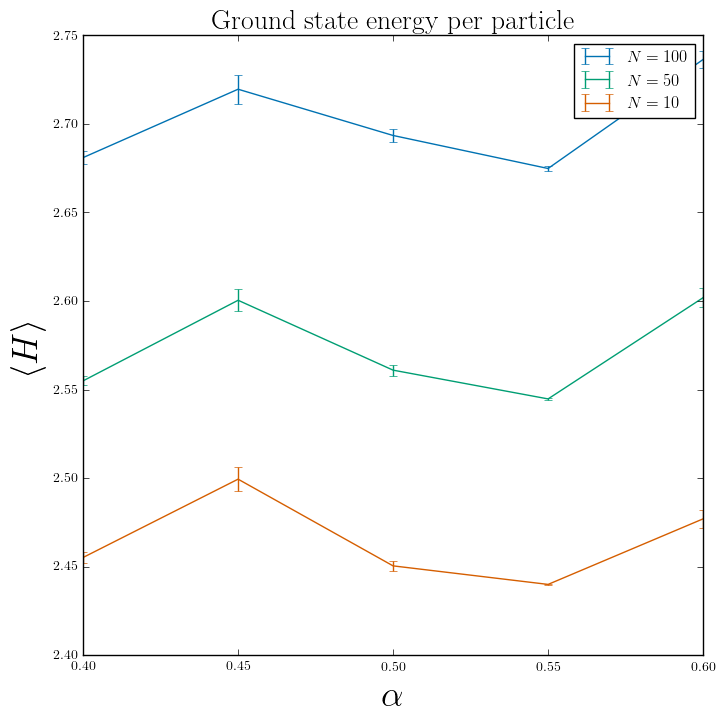

In [4]:
Es100, rhos100 = load_set('../data/interacting-run1_0_3_100_32768*')
Es100, rhos100 = np.asarray(Es100), np.asarray(rhos100)
Es100_errors = [blocking(e/100) for e in Es100]
Es50, rhos50 = load_set('../data/interacting-run1_0_3_50_131072*')
Es50, rhos50 = np.asarray(Es50), np.asarray(rhos50)
Es50_errors = [blocking(e/50) for e in Es50]
Es10, rhos10 = load_set('../data/interacting-run1_0_3_10_131072*')
Es10, rhos10 = np.asarray(Es10), np.asarray(rhos10)
Es10_errors = [blocking(e/10) for e in Es10]

fig, ax = plt.subplots(figsize=figsize)
ax.set_ylabel(r'$\langle H\rangle$', fontsize=axis_fontsize)
ax.set_xlabel(r'$\alpha$', fontsize=axis_fontsize)
ax.set_title(r'Ground state energy per particle', fontsize=title_fontsize)
alphas = [0.4, 0.45, 0.5, 0.55, 0.6]
ax.errorbar(alphas, np.mean(Es100, axis=1)/100, yerr=Es100_errors, label=r'$N=100$')
ax.errorbar(alphas, np.mean(Es50, axis=1)/50, yerr=Es50_errors, label=r'$N=50$')
ax.errorbar(alphas, np.mean(Es10, axis=1)/10, yerr=Es10_errors, label=r'$N=10$')
plt.legend(fontsize=12)
plt.savefig('../results/interacting-energy-per-particle.png')

for N in [10, 50, 100]:
    exec(r"""
print(r'''\begin{tabular}{|c|c|c|}\hline
$\,$ & $N=100$ & $\,$ \\ \hline
$\alpha$ & VMC & GP\\ \hline''')
for alpha, e, er in zip(alphas, np.mean(Es100,axis=1), Es100_errors):
    print(r'${:3.2f}$ & ${:5.3f} \pm {:5.6f}$ & ${:5.3f}$\\ \hline'.format(alpha, e, er, GP(alpha, 2.82843, 100)))
print(r'\end{tabular}')
""".replace('100', str(N)))
    print()

## Spesialized N10

In [5]:
(EN10,), rhosN10 = load_set('../data/N10-optimal-alpha-0.4978_N1048576*')
print(r'${:4.4f} \pm {:4.5f}$'.format(np.mean(EN10), blocking(EN10)))

$24.3984 \pm 0.00080$


## Density plots

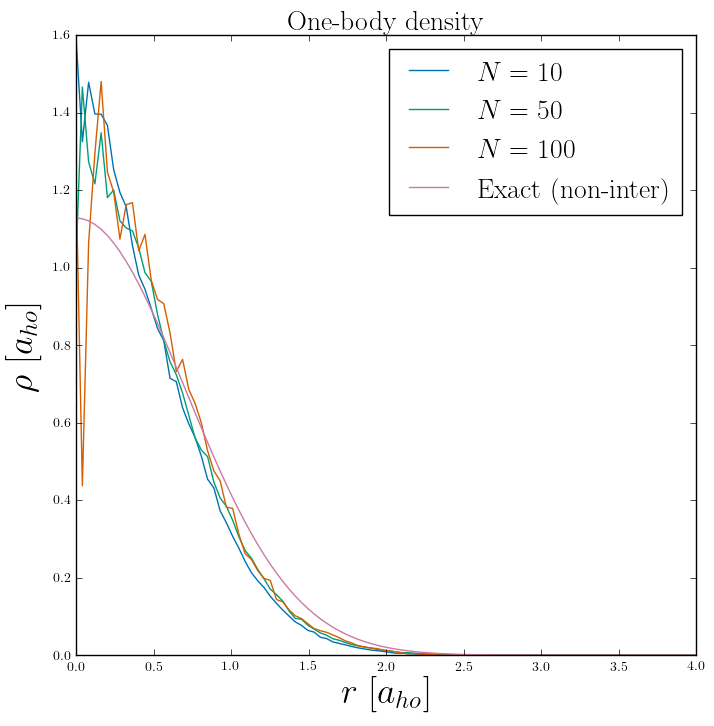

In [39]:
densities = np.array([rhos10[3], rhos50[3], rhos100[3]])
density_plot_multiple(densities, max_radius=4, labels=[r'$N=10$', r'$N=50$', r'$N=100$'],
                      draw_exact=True, saveas='../results/interacting-density.png')

In [18]:
densities / np.trapz(densities, axis=1).reshape(3, -1)

array([[  6.42576472e-02,   5.35480394e-02,   5.97483387e-02,
          5.64425280e-02,   5.64185654e-02,   5.52545154e-02,
          5.06387364e-02,   4.82566059e-02,   4.67619975e-02,
          4.27238268e-02,   3.96352557e-02,   3.81715243e-02,
          3.61706159e-02,   3.40867044e-02,   3.28077211e-02,
          2.88832628e-02,   2.85305527e-02,   2.58184290e-02,
          2.41247735e-02,   2.27220147e-02,   2.07610123e-02,
          1.83526543e-02,   1.74561673e-02,   1.50639005e-02,
          1.38181295e-02,   1.24030543e-02,   1.11624916e-02,
          9.77977414e-03,   8.61119271e-03,   7.77072084e-03,
          7.07578535e-03,   6.16243140e-03,   5.41242426e-03,
          4.72024297e-03,   4.09370337e-03,   3.48395072e-03,
          3.11079678e-03,   2.59934545e-03,   2.41550184e-03,
          1.88590681e-03,   1.74322209e-03,   1.39699549e-03,
          1.23716821e-03,   1.09133489e-03,   9.18455683e-04,
          7.80502979e-04,   6.64500874e-04,   5.53754285e-04,
        

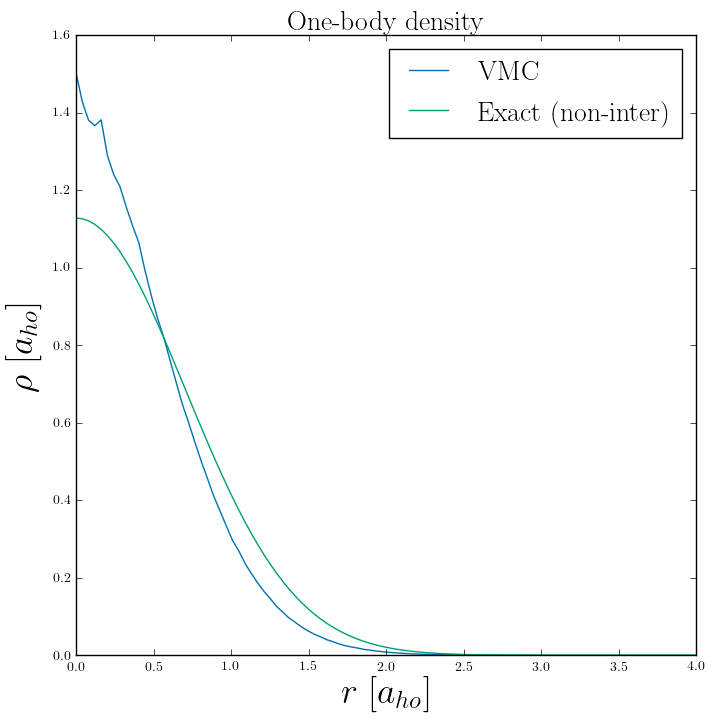

In [26]:
_, rho_ref, meta_ref = run_MC(n=10, dims=3, n_mc=2**20, alpha=0.5,
                              beta=2.82843, omega_z=2.82843, 
                              importance=False, step=0.5, n_bins=100, max_radius=4)
density_plot(rho_ref, alpha=0.5, max_radius=4, draw_exact=True)